In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!rm -rf sample_data
! cp -R /content/drive/My\ Drive/Datasets/Kannada-MNIST /content/

In [0]:
import pandas as pd
import numpy as np

from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform

from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

In [0]:
def identity_block(X, filter_size, n_filters):
    '''
        X: input to identity block
        n_filters: list of number of filters in each layer
        filter_size: size of filters (window size) to be used in middle convolution layer
    '''
    
    f1, f2, f3 = n_filters
    X_shortcut = X # Storing input to add it later
    
    # First layer of identity block
    X = Conv2D(filters = f1, kernel_size=(1, 1), strides=(1, 1), padding="valid")(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    
    # Second layer of identity block
    X = Conv2D(filters = f2, kernel_size=(filter_size, filter_size), strides=(1, 1), padding="same")(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    
    # Third layer
    X = Conv2D(filters = f3, kernel_size=(1, 1), strides=(1, 1), padding = "valid")(X)
    X = BatchNormalization(axis = 3)(X)
    
    # Now add the input to above X before applying relu
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [0]:
def convolutional_block(X, n_filters, filter_size, stride = 2):
    '''
        X: input to identity block
        n_filters: list of number of filters in each layer
        filter_size: size of filters (window size) to be used in middle convolution layer
        stride: stride to be used in short cut path convolution to reduce dimensions
    '''
    
    f1, f2, f3 = n_filters
    X_shortcut = X
    
    # First block
    X = Conv2D(filters = f1, kernel_size = (1, 1), strides = (stride, stride), padding = 'valid')(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    
    # Second block
    X = Conv2D(filters = f2, kernel_size = (filter_size, filter_size), strides = (1, 1), padding = 'same')(X)
    X = BatchNormalization(axis = 3) (X)
    X = Activation('relu')(X)
    
    # Third block
    X = Conv2D(filters = f3, kernel_size = (1, 1), strides = (1, 1), padding = 'valid')(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    
    # Shortcut convolution
    X_shortcut = Conv2D(filters = f3, kernel_size = (1, 1), strides = (stride, stride), padding='valid')(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut)
    
    
    # Add shortcut path to main path
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    return X

In [0]:
def ResNet50(input_shape = (28, 28, 1), classes = 10):
    
    # First define input with given shape
    X_input = Input(input_shape)
    
    X = ZeroPadding2D((3, 3))(X_input)
    
    X = Conv2D(filters = 64, kernel_size = (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides = (2, 2))(X)
    
    # Stage 2
    X = convolutional_block(X, filter_size = 3, n_filters = [64, 64, 256], stride = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    # Stage 3
    X = convolutional_block(X, filter_size = 3, n_filters = [128,128,512], stride = 2)
    X = identity_block(X, 3, [128,128,512])
    X = identity_block(X, 3, [128,128,512])
    X = identity_block(X, 3, [128,128,512])

    # Stage 4
    X = convolutional_block(X, filter_size = 3, n_filters = [256, 256, 1024], stride = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    # Stage 5
    X = convolutional_block(X, filter_size = 3, n_filters = [512, 512, 2048], stride = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    X = AveragePooling2D((2, 2), padding = 'same')(X)
    
    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model
    

In [0]:
model = ResNet50(input_shape = (28, 28, 1), classes = 10)

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
# constants
IMG_SIZE = 28
N_CHANNELS = 1 # because gray scale images

In [0]:
train_df = pd.read_csv('Kannada-MNIST/train.csv')
test_df = pd.read_csv('Kannada-MNIST/Dig-MNIST.csv')
pred_df = pd.read_csv('Kannada-MNIST/test.csv')

In [0]:
train_df = train_df.append(test_df)

In [0]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
print (f'Training set: {train_df.shape}')
print (f'To be Predicted: {pred_df.shape}')

Training set: (70240, 785)
To be Predicted: (5000, 785)


In [0]:
X_train = train_df.drop(['label'], axis = 1)
Y_train = train_df['label']
X_pred = pred_df.drop(['id'], axis = 1)

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.10)

In [0]:
X_train, X_test, X_pred = X_train.apply(lambda x: x/255), X_test.apply(lambda x: x/255), X_pred.apply(lambda x: x/255)

In [0]:
Y_train, Y_test = pd.get_dummies(Y_train), pd.get_dummies(Y_test)

In [0]:
X_train = X_train.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)
X_test = X_test.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)

In [0]:
print (f'Training images: {X_train.shape}')
print (f'Testing images: {X_test.shape}')

Training images: (63216, 28, 28, 1)
Testing images: (7024, 28, 28, 1)


In [0]:
Y_train = Y_train.to_numpy()

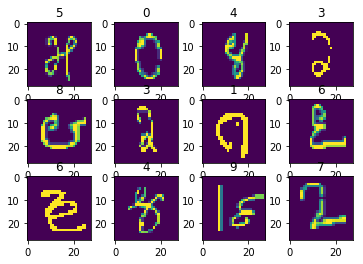

In [0]:
fig, ax = plt.subplots(nrows=3, ncols=4)
count=0
for row in ax:
    for col in row:
        col.set_title(np.argmax(Y_train[count, :]))
        col.imshow(X_train[count, :, :, 0])
        count += 1
plt.show()

In [0]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=8,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.15, # Randomly zoom image 
        width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


# This will just calculate parameters required to augment the given data. This won't perform any augmentations
datagen.fit(X_train)

In [0]:
# Set a learning rate annealer. Learning rate will be half after 3 epochs if accuracy is not increased
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)

In [0]:
batch_size=32
epochs = 10

In [0]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_test,Y_test),
                              steps_per_epoch=X_train.shape[0] // batch_size, 
                              callbacks=[learning_rate_reduction])

Epoch 1/5
1975/1975 [==============================] - 432s 219ms/step - loss: 1.5765 - acc: 0.6080 - val_loss: 1.6677 - val_acc: 0.5625
Epoch 2/5
   1/1975 [..............................] - ETA: 6:04 - loss: 1.3637 - acc: 0.6250

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1379: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_accuracy` which is not available. Available metrics are: val_loss,val_acc,loss,acc,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


1975/1975 [==============================] - 411s 208ms/step - loss: 0.7742 - acc: 0.7958 - val_loss: 0.4898 - val_acc: 0.8494
Epoch 3/5
1975/1975 [==============================] - 411s 208ms/step - loss: 0.9542 - acc: 0.7816 - val_loss: 9.2491 - val_acc: 0.2017
Epoch 4/5
1975/1975 [==============================] - 414s 209ms/step - loss: 0.6225 - acc: 0.8572 - val_loss: 0.1827 - val_acc: 0.9449
Epoch 5/5
 715/1975 [=========>....................] - ETA: 4:17 - loss: 1.0389 - acc: 0.7890

In [0]:
%matplotlib inline
def PlotLoss(his, epoch):
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, epoch), his.history["loss"], label="train_loss")
    plt.plot(np.arange(0, epoch), his.history["val_loss"], label="val_loss")
    plt.title("Training Loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    plt.show()

def PlotAcc(his, epoch):
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, epoch), his.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, epoch), his.history["val_accuracy"], label="val_accuracy")
    plt.title("Training Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.legend(loc="upper right")
    plt.show()

In [0]:
PlotLoss(history, epochs)
PlotAcc(history, epochs)

In [0]:
import pickle

In [0]:
model.save(f'model.h5')
with open(f'his.pkl', 'wb') as output:
    pickle.dump(histories[model_type], output, pickle.HIGHEST_PROTOCOL)

In [0]:
from IPython.display import FileLink
FileLink(r'model.h5')